# FSRS4Anki v4.4.0 Simulator

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/v4.4.0/fsrs4anki_simulator.ipynb)

↑ Click the above button to open the simulator on Google Colab.

> If you can't see the button and are located in the Chinese Mainland, please use a proxy or VPN.

In [1]:
# parameters for FSRS
w = [1.14, 1.01, 5.44, 14.67, 5.3024, 1.5662, 1.2503, 0.0028, 1.5489, 0.1763, 0.9953, 2.7473, 0.0179, 0.3105, 0.3976, 0.0, 2.0902]
requestRetention = 0.87  # recommended setting: 0.8 ~ 0.9

# parameters for Anki
graduatingInterval = 1
easyInterval = 4
easyBonus = 1.3
hardInterval = 1.2
intervalModifier = 1
newInterval = 0
minimumInterval = 1
leechThreshold = 8
leechSuspend = False

# common parameters
maximumInterval = 36500

new_cards_limits = 20
review_limits = 200
max_time_limts = 10000
learn_days = 300
deck_size = 20000

# get the true time from review logs
filename = "collection-2022-09-18@13-21-58.colpkg"

# smooth curves
moving_average_period = 14

In [2]:
import torch
import random
import os
import time
import zipfile
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch import nn

# Extract the collection file or deck file to get the .anki21 database.
with zipfile.ZipFile(f'./{filename}', 'r') as zip_ref:
    zip_ref.extractall('./')
    print("Extract successfully!")
if os.path.isfile("collection.anki21b"):
    os.remove("collection.anki21b")
    raise Exception(
        "Please export the file with `support older Anki versions` if you use the latest version of Anki.")
elif os.path.isfile("collection.anki21"):
    con = sqlite3.connect("collection.anki21")
elif os.path.isfile("collection.anki2"):
    con = sqlite3.connect("collection.anki2")
else:
    raise Exception("Collection not exist!")
cur = con.cursor()
res = cur.execute("SELECT * FROM revlog")
revlog = res.fetchall()

df = pd.DataFrame(revlog)
df.columns = ['id', 'cid', 'usn', 'ease', 'ivl',
              'last_lvl', 'factor', 'time', 'type']

df = df[(df['cid'] <= time.time() * 1000) &
        (df['id'] <= time.time() * 1000)].copy()
df.sort_values(by=['cid', 'id'], inplace=True, ignore_index=True)


type_sequence = np.array(df['type'])
time_sequence = np.array(df['time'])

type_block = dict()
type_count = dict()
type_time = dict()
last_t = type_sequence[0]
type_block[last_t] = 1
type_count[last_t] = 1
type_time[last_t] = time_sequence[0]
for i,t in enumerate(type_sequence[1:]):
    type_count[t] = type_count.setdefault(t, 0) + 1
    type_time[t] = type_time.setdefault(t, 0) + time_sequence[i]
    if t != last_t:
        type_block[t] = type_block.setdefault(t, 0) + 1
    last_t = t

new_time = round(type_time[0]/type_block[0]/1000, 1)
recall_time = round(type_time[1]/type_count[1]/1000, 1)
forget_time = round(type_time[2]/type_block[2]/1000 + recall_time, 1)

print(f"average time for new cards: {new_time}s")
print(f"average time for failed cards: {forget_time}s")
print(f"average time for recalled cards: {recall_time}s")

new_card_revlog = df[(df['factor'] == 0) & (df['ease'] != 0)]
new_card_rating_distribution = new_card_revlog.groupby(
    'ease')['id'].count()/new_card_revlog['id'].count()
recall_card_revlog = df[(df['type'] == 1) & (df['ease'] != 1)]
recall_card_rating_distribution = recall_card_revlog.groupby(
    'ease')['id'].count()/recall_card_revlog['id'].count()


def generate_rating(review_type):
    if review_type == 'new':
        distribution = new_card_rating_distribution
    elif review_type == 'recall':
        distribution = recall_card_rating_distribution
    return random.choices(distribution.index.values, weights=distribution.values)[0]


Extract successfully!
average time for new cards: 19.6s
average time for failed cards: 25.0s
average time for recalled cards: 8.0s


In [3]:
def power_forgetting_curve(t, s):
    return (1 + t / (9 * s)) ** -1

class FSRS(nn.Module):
    def __init__(self, w):
        super(FSRS, self).__init__()
        self.w = nn.Parameter(torch.FloatTensor(w))
        self.zero = torch.FloatTensor([0.0])

    def stability_after_success(self, s, new_d, r, rating):
        hard_penalty = torch.where(rating == 2, self.w[15], torch.tensor(1.0))
        easy_bonus = torch.where(rating == 4, self.w[16], torch.tensor(1.0))
        new_s = s * (1 + torch.exp(self.w[8]) *
                        (11 - new_d) *
                        torch.pow(s, -self.w[9]) *
                        (torch.exp((1 - r) * self.w[10]) - 1) * 
                        hard_penalty * 
                        easy_bonus)
        return new_s

    def stability_after_failure(self, s, new_d, r):
        new_s = self.w[11] * \
                torch.pow(new_d, -self.w[12]) * \
                (torch.pow(s + 1, self.w[13]) - 1) * \
                torch.exp((1 - r) * self.w[14])
        return new_s

    def forward(self, x, s, d):
        '''
        :param x: [review interval, review response]
        :param s: stability
        :param d: difficulty
        :return:
        '''
        if torch.equal(s, self.zero):
            # first learn, init memory states
            new_s = self.w[x[1].long()-1]
            new_d = self.w[4] - self.w[5] * (x[1] - 3)
            new_d = new_d.clamp(1, 10)
        else:
            r = power_forgetting_curve(x[0], s)
            new_d = d - self.w[6] * (x[1] - 3)
            new_d = self.mean_reversion(self.w[4], new_d)
            new_d = new_d.clamp(1, 10)
            # recall
            if x[1] > 1:
                new_s = self.stability_after_success(s, new_d, r, x[1])
            # forget
            else:
                new_s = self.stability_after_failure(s, new_d, r)
        return new_s, new_d

    def mean_reversion(self, init, current):
        return self.w[7] * init + (1-self.w[7]) * current


def lineToTensor(line):
    ivl = line[0].split(',')
    response = line[1].split(',')
    tensor = torch.zeros(len(response), 2)
    for li, response in enumerate(response):
        tensor[li][0] = int(ivl[li])
        tensor[li][1] = int(response)
    return tensor

class Collection:
    def __init__(self):
        self.model = FSRS(w)
        self.model.eval()

    def states(self, t_history, r_history):
        with torch.no_grad():
            line_tensor = lineToTensor(
                list(zip([str(t_history)], [str(r_history)]))[0])
            output_t = [(self.model.zero, self.model.zero)]
            for input_t in line_tensor:
                output_t.append(self.model(input_t, *output_t[-1]))
            return output_t[-1]

    def next_states(self, states, t, r):
        with torch.no_grad():
            return self.model(torch.FloatTensor([t, r]), *states)

    def init(self):
        t = 0
        r = generate_rating('new')
        p = round(new_card_rating_distribution[r], 2)
        new_states = self.states(t, r)
        return r, t, p, new_states


  0%|          | 0/300 [00:00<?, ?it/s]

scheduler: anki
learned cards: 6000
time in minutes: 9481.7
remembered cards: 5585
time per remembered card: 1.7
leeches: 31


  0%|          | 0/300 [00:00<?, ?it/s]

scheduler: fsrs
learned cards: 6000
time in minutes: 8134.6
remembered cards: 5592
time per remembered card: 1.45
leeches: 38


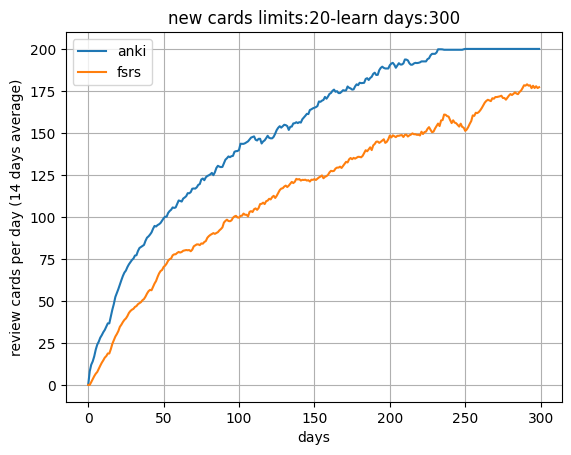

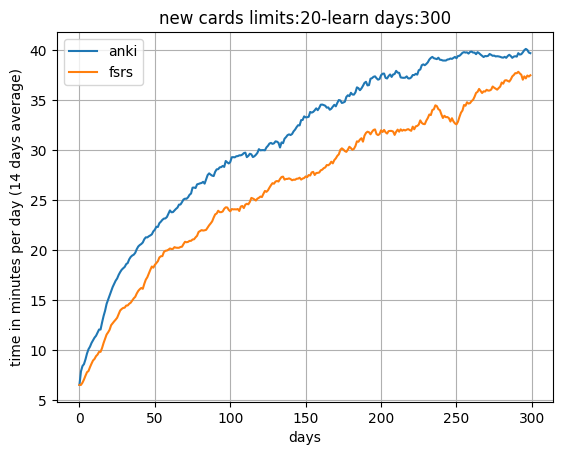

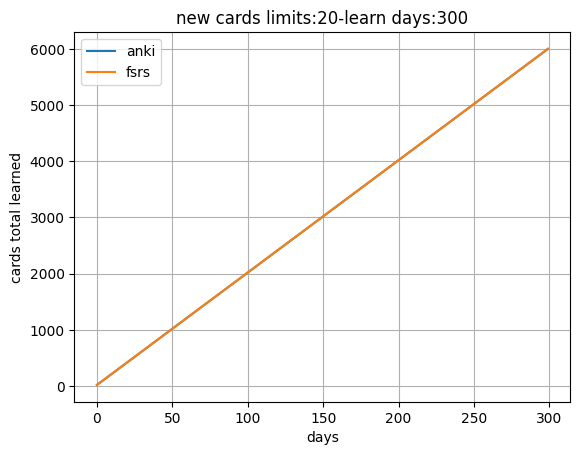

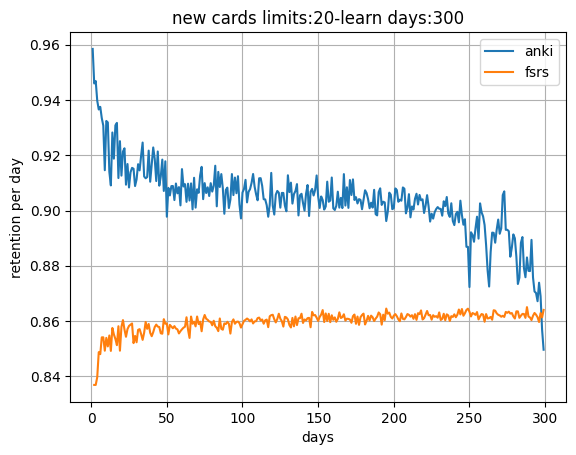

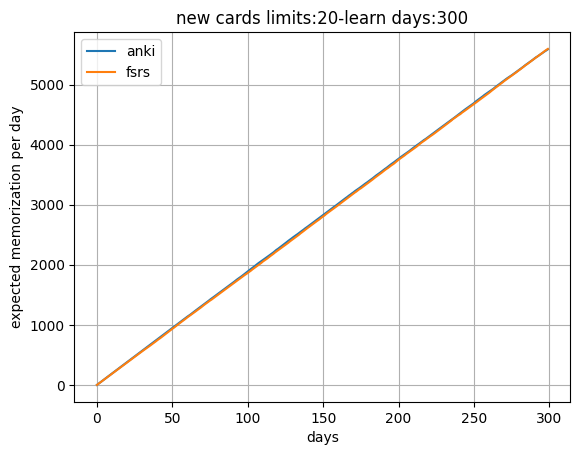

In [4]:
feature_list = ['difficulty', 'stability', 'retrievability', 'delta_t', 'reps', 'lapses', 'last_date', 'due',
                'r_history', 't_history', 'p_history', 'states', 'time', 'factor']
dtypes = np.dtype([
    ('difficulty', float),
    ('stability', float),
    ('retrievability', float),
    ('delta_t', int),
    ('reps', int),
    ('lapses', int),
    ('last_date', int),
    ('due', int),
    ('r_history', str),
    ('t_history', str),
    ('p_history', str),
    ('states', object),
    ('time', int),
    ('factor', float)
])
field_map = {key: i for i, key in enumerate(feature_list)}

def fsrs4anki_scheduler(last_stability, stability, rating):
    def constrain_interval(stability):
        if stability > 0:
            return min(max(1, round(9 * stability * (1 / requestRetention - 1))), maximumInterval)
        else:
            return 1
    if last_stability is None:
        return constrain_interval(stability)
    again_interval = constrain_interval(stability)
    hard_interval = constrain_interval(stability)
    good_interval = max(constrain_interval(stability), hard_interval + 1)
    easy_interval = max(constrain_interval(stability), good_interval + 1)
    if rating == 1:
        return again_interval
    if rating == 2:
        return hard_interval
    if rating == 3:
        return good_interval
    if rating == 4:
        return easy_interval
    return maximumInterval


def anki_scheduler(interval, real_interval, factor, rating):
    if factor is None:
        return (graduatingInterval, 2.5) if rating != 4 else (easyInterval, 2.5)
    delay = real_interval - interval
    again_interval = max(round(interval * newInterval * intervalModifier + 0.01), minimumInterval)
    hard_interval = max(round(interval * hardInterval * intervalModifier + 0.01), interval + 1, minimumInterval)
    good_interval = max(round((interval + delay / 2) * factor * intervalModifier + 0.01), hard_interval + 1, minimumInterval)
    easy_interval = max(round(real_interval * factor * intervalModifier * easyBonus + 0.01), good_interval + 1, minimumInterval)
    if rating == 1:
        return again_interval, max(factor - 0.2, 1.3)
    if rating == 2:
        return hard_interval, max(factor - 0.15, 1.3)
    if rating == 3:
        return good_interval, max(factor, 1.3)
    if rating == 4:
        return easy_interval, max(factor + 0.15, 1.3)
    return maximumInterval, factor

def scheduler(scheduler_name, fsrs_inputs, anki_inputs):
    if scheduler_name == "anki":
        return anki_scheduler(*anki_inputs)
    elif scheduler_name == "fsrs":
        return fsrs4anki_scheduler(*fsrs_inputs), 2.5
    return None


for scheduler_name in ('anki', 'fsrs'):
    new_card_per_day = np.array([0] * learn_days)
    new_card_per_day_average_per_period = np.array([0.0] * learn_days)
    review_card_per_day = np.array([0.0] * learn_days)
    review_card_per_day_average_per_period = np.array([0.0] * learn_days)
    time_per_day = np.array([0.0] * learn_days)
    time_per_day_average_per_period = np.array([0.0] * learn_days)
    learned_per_day = np.array([0.0] * learn_days)
    retention_per_day = np.array([0.0] * learn_days)
    expected_memorization_per_day = np.array([0.0] * learn_days)

    card = pd.DataFrame(np.full(deck_size, np.nan, dtype=dtypes),
                        index=range(deck_size), columns=feature_list)
    card['reps'] = 0
    card['lapses'] = 0
    card['due'] = learn_days

    student = Collection()
    random.seed(2022)
    for day in tqdm(range(learn_days)):
        reviewed = 0
        learned = 0
        review_time_today = 0
        learn_time_today = 0

        card["delta_t"] = day - card["last_date"]
        card["retrievability"] = np.power(1 + card['delta_t'] / (9 * card['stability']), -1)
        need_review = card[card['due'] <= day] if leechSuspend == False else card[(card['due'] <= day) & (card['lapses'] < leechThreshold)]
        retention_per_day[day] = need_review['retrievability'].mean()
        for idx in need_review.index:
            if reviewed >= review_limits or review_time_today + learn_time_today >= max_time_limts:
                break

            reviewed += 1
            last_date = card.iat[idx, field_map['last_date']]
            due = card.iat[idx, field_map['due']]
            factor = card.iat[idx, field_map['factor']]
            card.iat[idx, field_map['last_date']] = day
            ivl = card.iat[idx, field_map['delta_t']]
            card.iat[idx, field_map['t_history']] += f',{ivl}'

            stability = card.iat[idx, field_map['stability']]
            retrievability = card.iat[idx, field_map['retrievability']]
            card.iat[idx, field_map['p_history']] += f',{retrievability:.2f}'
            reps = card.iat[idx, field_map['reps']]
            lapses = card.iat[idx, field_map['lapses']]
            states = card.iat[idx, field_map['states']]

            if random.random() < retrievability:
                review_time_today += recall_time

                rating = generate_rating('recall')
                card.iat[idx, field_map['r_history']] += f',{rating}'
                new_states = student.next_states(states, ivl, rating)
                new_stability = float(new_states[0])
                new_difficulty = float(new_states[1])
                card.iat[idx, field_map['stability']] = new_stability
                card.iat[idx, field_map['difficulty']] = new_difficulty
                card.iat[idx, field_map['states']] = new_states
                card.iat[idx, field_map['reps']] = reps + 1
                card.iat[idx, field_map['time']] += recall_time

                delta_t, factor = scheduler(scheduler_name, (stability, new_stability, rating),(due-last_date, ivl, factor, rating))
                card.iat[idx, field_map['factor']] = factor
                card.iat[idx, field_map['due']] = day + delta_t

            else:
                review_time_today += forget_time

                rating = 1
                card.iat[idx, field_map['r_history']] += f',{rating}'

                new_states = student.next_states(states, ivl, 1)
                new_stability = float(new_states[0])
                new_difficulty = float(new_states[1])

                card.iat[idx, field_map['stability']] = new_stability
                card.iat[idx, field_map['difficulty']] = new_difficulty
                card.iat[idx, field_map['states']] = new_states

                reps = 0
                lapses = lapses + 1

                card.iat[idx, field_map['reps']] = reps
                card.iat[idx, field_map['lapses']] = lapses

                delta_t, factor = scheduler(scheduler_name, (stability, new_stability, rating),(due-last_date, ivl, factor, rating))
                card.iat[idx, field_map['due']] = day + delta_t
                card.iat[idx, field_map['factor']] = factor
                card.iat[idx, field_map['time']] += forget_time

        need_learn = card[card['stability'].isna()]

        for idx in need_learn.index:
            if learned >= new_cards_limits or review_time_today + learn_time_today >= max_time_limts:
                break
            learned += 1
            learn_time_today += new_time
            card.iat[idx, field_map['last_date']] = day

            card.iat[idx, field_map['reps']] = 1
            card.iat[idx, field_map['lapses']] = 0

            r, t, p, new_states = student.init()
            new_stability = float(new_states[0])
            new_difficulty = float(new_states[1])

            card.iat[idx, field_map['r_history']] = str(r)
            card.iat[idx, field_map['t_history']] = str(t)
            card.iat[idx, field_map['p_history']] = str(p)
            card.iat[idx, field_map['stability']] = new_stability
            card.iat[idx, field_map['difficulty']] = new_difficulty
            card.iat[idx, field_map['states']] = new_states

            delta_t, factor = scheduler(scheduler_name, (None, new_stability, r), (None, None, None, r))
            card.iat[idx, field_map['due']] = day + delta_t
            card.iat[idx, field_map['time']] = new_time
            card.iat[idx, field_map['factor']] = factor

        new_card_per_day[day] = learned
        review_card_per_day[day] = reviewed
        learned_per_day[day] = learned_per_day[day - 1] + learned
        time_per_day[day] = review_time_today + learn_time_today
        expected_memorization_per_day[day] = sum(card[card['retrievability'] > 0]['retrievability'])

        if day >= moving_average_period:
            new_card_per_day_average_per_period[day] = np.true_divide(
                new_card_per_day[day - moving_average_period:day].sum(), moving_average_period)
            review_card_per_day_average_per_period[day] = np.true_divide(
                review_card_per_day[day - moving_average_period:day].sum(), moving_average_period)
            time_per_day_average_per_period[day] = np.true_divide(
                time_per_day[day - moving_average_period:day].sum(), moving_average_period)
        else:
            new_card_per_day_average_per_period[day] = np.true_divide(
                new_card_per_day[:day + 1].sum(), day + 1)
            review_card_per_day_average_per_period[day] = np.true_divide(
                review_card_per_day[:day + 1].sum(), day + 1)
            time_per_day_average_per_period[day] = np.true_divide(
                time_per_day[:day + 1].sum(), day + 1)

    total_learned = sum(new_card_per_day)
    total_time = sum(time_per_day)
    total_remembered = int(card['retrievability'].sum())
    total_leeches = len(card[card['lapses'] >= leechThreshold])

    plt.figure(1)
    plt.plot(review_card_per_day_average_per_period, label=f'{scheduler_name}')
    plt.figure(2)
    plt.plot(time_per_day_average_per_period/60, label=f'{scheduler_name}')
    plt.figure(3)
    plt.plot(learned_per_day, label=f'{scheduler_name}')
    plt.figure(4)
    plt.plot(retention_per_day, label=f'{scheduler_name}')
    plt.figure(5)
    plt.plot(expected_memorization_per_day, label=f'{scheduler_name}')

    print('scheduler:', scheduler_name)
    print('learned cards:', total_learned)
    print('time in minutes:', round(total_time/60,1))
    print('remembered cards:', total_remembered)
    print('time per remembered card:', round(total_time/60/total_remembered,2))
    print('leeches:', total_leeches)

    save = card[card['retrievability'] > 0].copy()
    save['stability'] = round(save['stability'], 2)
    save['retrievability'] = round(save['retrievability'], 2)
    save['difficulty'] = round(save['difficulty'], 2)
    save['factor'] = round(save['factor'], 2)
    save['time'] = round(save['time'], 2)

    save.to_csv(f'./simulator-{scheduler_name}.tsv', index=False, sep='\t')

plt.figure(1)
plt.title(f"new cards limits:{new_cards_limits}-learn days:{learn_days}")
plt.xlabel("days")
plt.ylabel(f"review cards per day ({moving_average_period} days average)")
plt.legend()
plt.grid(True)
plt.figure(2)
plt.title(f"new cards limits:{new_cards_limits}-learn days:{learn_days}")
plt.xlabel("days")
plt.ylabel(f"time in minutes per day ({moving_average_period} days average)")
plt.legend()
plt.grid(True)
plt.figure(3)
plt.title(f"new cards limits:{new_cards_limits}-learn days:{learn_days}")
plt.xlabel("days")
plt.ylabel(f"cards total learned")
plt.legend()
plt.grid(True)
plt.figure(4)
plt.title(f"new cards limits:{new_cards_limits}-learn days:{learn_days}")
plt.xlabel("days")
plt.ylabel("retention per day")
plt.legend()
plt.grid(True)
plt.figure(5)
plt.title(f"new cards limits:{new_cards_limits}-learn days:{learn_days}")
plt.xlabel("days")
plt.ylabel("expected memorization per day")
plt.legend()
plt.grid(True)
plt.show()
plt.close('all')
